In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modules import forecast
from itertools import combinations
from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2_score 

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.model_selection import KFold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read SCM data

In [180]:
# contains selected ERA-features, as identified in 3_train_model.ipynb
era = pd.read_csv("data/features/era_features_and_target_v4.csv")

# contains bias-adjusted monthly tmean and rainfall data for each model and init_month
nmme = pd.read_csv("nmme/data/features/bias_adjusted_nmme_features_v2.csv")
clik = pd.read_csv("clik-apcc/data/features/bias_adjusted_clik_features_v2.csv")
c3s = pd.read_csv("c3s/data/features/bias_adjusted_c3s_features_v2.csv")

scm = pd.concat([nmme, clik, c3s], ignore_index=True).drop_duplicates()

#nmme = nmme.loc[nmme["model"] != "ERA"].reset_index(drop=True).merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
#clik = clik.loc[clik["model"] != "ERA"].reset_index(drop=True).merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
#c3s = c3s.loc[c3s["model"] != "ERA"].reset_index(drop=True).merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")

#x_y_cv = pd.concat([era, clik, c3s, nmme], ignore_index=True).drop_duplicates()
#x_y_cv = x_y_cv.loc[(x_y_cv["year"] <= 2016) & (x_y_cv["init_month"] >= 9), [c for c in x_y_cv.columns if "_8" not in c]].reset_index(drop=True)

In [181]:
scm.head()

,model,year,init_month,tmean_bahia blanca_8,tmean_bahia blanca_9,tmean_bahia blanca_10,tmean_bahia blanca_11,tmean_coronel dorrego_8,tmean_coronel dorrego_9,tmean_coronel dorrego_10,...,rain_hipolito yrigoyen_10,rain_hipolito yrigoyen_11,rain_saavedra_8,rain_saavedra_9,rain_saavedra_10,rain_saavedra_11,rain_santa fe san justo_8,rain_santa fe san justo_9,rain_santa fe san justo_10,rain_santa fe san justo_11
0,CCSM4,1993,9,10.427311,10.858146,15.720639,20.091838,10.111882,10.415647,14.778288,...,0.001778,0.002045,0.000088,0.000846,0.003313,0.002034,0.000487,0.001042,0.003168,0.001817
1,CCSM4,1993,10,10.427311,12.046370,14.356520,17.570112,10.111882,11.635531,13.209805,...,0.002059,0.003333,0.000088,0.001263,0.001976,0.002148,0.000487,0.000991,0.003426,0.003587
2,CCSM4,1993,11,10.427311,12.046370,15.487858,17.825245,10.111882,11.635531,14.788216,...,0.002157,0.004109,0.000088,0.001263,0.002178,0.004433,0.000487,0.000991,0.013321,0.007506
3,CCSM4,1994,9,9.458317,10.773643,14.596843,17.609509,9.101888,10.312850,13.858998,...,0.004420,0.003932,0.001733,0.001092,0.003331,0.003407,0.002182,0.002031,0.004507,0.005347
4,CCSM4,1994,10,9.458317,12.393457,13.163665,18.017148,9.101888,11.997054,12.631005,...,0.005185,0.002917,0.001733,0.000632,0.002209,0.003298,0.002182,0.003066,0.005091,0.003223


### 2. Expand features through basis functions

In [182]:
def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with tmean_squared, rain_squared, and tmean_times_rain features
    """ 
    filtered_data = data.loc[data["year"] < 2017].reset_index(drop=True)
    standardized_data = []
    for year in filtered_data["year"].unique().tolist():
        # split data
        X_train = filtered_data.loc[filtered_data["year"] != year, [c for c in filtered_data.columns if ("rain" in c) or ("tmean" in c)]].reset_index(drop=True)
        X_val = filtered_data.loc[(filtered_data["year"] == year) & (filtered_data["model"] != "ERA"), [c for c in filtered_data.columns if ("rain" in c) or ("tmean" in c)]].reset_index(drop=True)
        y_val = filtered_data.loc[(filtered_data["year"] == year) & (filtered_data["model"] != "ERA"), [c for c in filtered_data.columns if ("rain" not in c) and ("tmean" not in c)]].reset_index(drop=True)
        X_columns = X_val.columns
        
        #print("X_train.shape {}, X_val.shape {}, y_val.shape {}".format(X_train.shape, X_val.shape, y_val.shape))
        #print(len(X_val.values.flatten().tolist()))
    
        scaler = StandardScaler()
        X_val_standardized = scaler.fit(X_train).transform(X_val)
        #print(len(X_val_standardized.flatten()))
        X_val_standardized = pd.DataFrame(X_val_standardized, columns=X_columns)
        standardized_df = pd.concat([y_val, X_val_standardized], axis=1)
        standardized_data.append(standardized_df)
    
    df_standardized = pd.concat(standardized_data, ignore_index=True)
    X = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" in c) or ("tmean" in c)]].reset_index(drop=True)
    y = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" not in c) and ("tmean" not in c)]].reset_index(drop=True)
    X_columns = X.columns
    # store features and target in variables for better readability
    X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
    X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]
    
    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain * X_temp.values
    X_tmean_squared.columns = ["tmean_squared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rain_squared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmean_rain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True))
    data_expanded = pd.concat([y, X], axis=1)
    
    return data_expanded

In [183]:
climate_models = [c for c in scm.model.unique().tolist() if c != "ERA"]
init_months = [9, 10, 11]
li = []
for model in climate_models:
    for month in init_months:
        filtered_scm = scm.loc[(scm["model"].isin([model, "ERA"])) & (scm["init_month"].isin([month, 12]))].reset_index(drop=True)
        filtered_scm_basis_expansion = apply_basis_expansion(filtered_scm)
        li.append(filtered_scm_basis_expansion)
relevant_columns = [c for c in era.columns if c not in ['yield [kg/ha]', 'yield anomaly [%]']]
scm_basis_expansion = pd.concat(li, ignore_index=True).drop_duplicates()[relevant_columns]

In [184]:
scm_basis_expansion.loc[(scm_basis_expansion["model"].isin(["NCEP", "DWD"])) & (scm_basis_expansion["year"] == 1993)]

,model,year,init_month,tmean_rain_santa fe san justo_11,rain_squared_hipolito yrigoyen_9,tmean_rain_santa fe san justo_10,tmean_squared_bahia blanca_11,tmean_rain_bahia blanca_9,rain_squared_santa fe san justo_11,tmean_squared_santa fe san justo_11,tmean_rain_bahia blanca_11,tmean_rain_hipolito yrigoyen_11
216,NCEP,1993,9,0.962175,0.231268,-1.423595,2.257941,0.232650,0.348708,2.654891,1.261879,1.563213
240,NCEP,1993,10,0.582099,0.256655,1.938507,1.736548,-0.101273,0.309747,1.093922,1.150399,1.134292
264,NCEP,1993,11,0.321567,0.256655,-2.176832,0.890114,-0.101273,0.241634,0.427941,0.601497,0.082165
720,DWD,1993,9,-0.010214,0.241714,0.013700,0.096195,0.659746,0.010425,0.010006,-0.243579,-0.049524
744,DWD,1993,10,-0.180566,0.256655,-1.081441,0.012689,-0.101273,1.698810,0.019192,0.120355,-0.111118
768,DWD,1993,11,-0.135478,0.256655,-2.176832,0.210967,-0.101273,0.142588,0.128723,-0.257634,-0.040100


#### Bring ERA features and SCM features together and include yield target column

In [185]:
scm_basis_expansion = scm_basis_expansion.merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
x_y_cv = pd.concat([era, scm_basis_expansion], ignore_index=True).drop_duplicates()

In [186]:
relevant_columns = [c for c in x_y_cv.columns if ("rain" in c) or ("tmean" in c)]

### Identify SCM that are capable of forecasting features

In [195]:
climate_models = [c for c in scm.model.unique().tolist() if c != "ERA"]
init_months = [9, 10, 11]
good_models = []
model_to_r2 = {}
for model in climate_models:
    model_to_r2[model] = {}
    for month in init_months:
        list_of_r2 = []
        relevant_cols = [c for c in relevant_columns if int(c.split("_")[-1]) >= month]
        for col in relevant_cols:
            predicted = x_y_cv.loc[(x_y_cv["model"] == model) & (x_y_cv["init_month"] == month), col].reset_index(drop=True)
            observed = x_y_cv.loc[(x_y_cv["model"] == "ERA") & (x_y_cv["init_month"] == 12), col].reset_index(drop=True)
            current_r2 = np.round(r2_score(observed, predicted),2)
            if current_r2 > 0:
                good_models.append(model)
                print("R2 is {} with model {} for init_mont {} and feature {}".format(current_r2, model, month, col))
            list_of_r2.append(r2_score(observed, predicted))
            #li.append(filtered_scm_basis_expansion)
        mean_r2 = sum(list_of_r2) / len(list_of_r2)
        
        model_to_r2[model][month] = mean_r2
good_models = list(set(good_models))
#model_to_r2
#relevant_columns = [c for c in era.columns if c not in ['yield [kg/ha]', 'yield anomaly [%]']]
#scm_basis_expansion = pd.concat(li, ignore_index=True).drop_duplicates()[relevant_columns]

R2 is 0.13 with model GFDL for init_mont 9 and feature tmean_rain_bahia blanca_9
R2 is 0.12 with model GFDL for init_mont 10 and feature tmean_squared_bahia blanca_11
R2 is 0.18 with model GFDL for init_mont 10 and feature tmean_squared_santa fe san justo_11
R2 is 0.01 with model GFDL for init_mont 11 and feature tmean_rain_santa fe san justo_11
R2 is 0.02 with model NASA for init_mont 11 and feature tmean_rain_santa fe san justo_11
R2 is 0.08 with model NASA for init_mont 11 and feature tmean_squared_bahia blanca_11
R2 is 0.23 with model NASA for init_mont 11 and feature tmean_squared_santa fe san justo_11
R2 is 0.19 with model NCEP for init_mont 11 and feature tmean_squared_bahia blanca_11
R2 is 0.17 with model NCEP for init_mont 11 and feature tmean_squared_santa fe san justo_11
R2 is 0.52 with model BOM for init_mont 11 and feature tmean_squared_santa fe san justo_11
R2 is 0.01 with model CWB for init_mont 10 and feature tmean_rain_santa fe san justo_11
R2 is 0.23 with model CWB fo

In [196]:
good_models

['BOM', 'ECCC', 'GFDL', 'CWB', 'NASA', 'ECMWF', 'METFR', 'JMA', 'KMA', 'NCEP']

We filter GFDL, NASA, NCEP, CWB, KMA, ECCC, ECMWF, JMA

In [197]:
x_y_cv_filtered = x_y_cv.loc[x_y_cv["model"].isin(['ERA', 'BOM', 'ECCC', 'GFDL', 'CWB', 'NASA', 'ECMWF', 'METFR', 'JMA', 'KMA', 'NCEP'])].reset_index(drop=True)

### 3. Train model

In [199]:
models = good_models + ["ERA"]
results_all = pd.DataFrame(0, index=models, columns=[9, 10, 11])
for im in [9, 10, 11]:
    for model in models:
        res, _ = forecast.kfold_cross_validation(x_y_cv_filtered, model=model, init=im, no_of_features=6)
        # rmse
        #metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        # mae
        #metric = np.round(mae(res["predicted"], res["yield anomaly [%]"]), 4)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        # coefficient of determination
        metric = r2_score(res["yield anomaly [%]"], res["predicted"])
        
        results_all.loc[model, im] = np.round(metric, 2)

results_all.transpose()

,BOM,ECCC,GFDL,CWB,NASA,ECMWF,METFR,JMA,KMA,NCEP,ERA
9,-0.93,-0.76,-0.61,-0.45,0.01,-0.75,-0.73,-0.42,-1.06,-0.36,0.73
10,0.26,-0.01,0.29,0.16,-0.10,0.05,0.19,0.22,0.23,-0.02,0.73
11,0.14,0.22,0.14,0.16,0.43,0.07,0.18,0.18,0.07,0.14,0.73


#### Using the R2 metric, we identify that forecast in September are not skillful (R2 < 0). Hence from now on, we will base our analysis on forecasts made in Oktober.

In [200]:
x_y_cv_filtered = x_y_cv_filtered.loc[x_y_cv_filtered["init_month"].isin([10, 12])].reset_index(drop=True)

#### 3.5 MME

analyze average correlation coefficient across all MME permutations of sizes between 1 and 7

In [204]:
relevant_models = good_models
mme_size_to_results = {}
for size in range(1,11):
    mme_size_to_results[size] = []
    model_combinations = list(combinations([c for c in relevant_models if c != "ERA"], size))
    print(len(model_combinations))
    #running_sum = 0
    for i in range(0, len(model_combinations)):
        combi = list(model_combinations[i])
        mme = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(combi)].assign(model="MME_{}".format("_".join(combi))).groupby(["model", "year", "init_month"]).mean().reset_index()
        x_y_cv_mme = pd.concat([mme, x_y_cv_filtered], ignore_index=True)
        res, _ = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(combi)), init=10, no_of_features=6)
        #metric = pearsonr(res["yield anomaly [%]"], res["predicted"])[0]
        metric = r2_score(res["yield anomaly [%]"], res["predicted"])
        #running_sum += metric
        mme_size_to_results[size].append(np.round(metric, 4))
        if metric > 0.45:
            print("R2 is {} for {}".format(metric, "_".join(combi)))
    #mme_size_to_results[size] = np.round(running_sum / len(model_combinations), 4)
    print(mme_size_to_results)
    

10
{1: [0.2565, -0.0063, 0.2892, 0.1578, -0.1006, 0.0469, 0.1865, 0.2182, 0.2291, -0.0227]}
45
R2 is 0.4682274881894736 for BOM_GFDL
{1: [0.2565, -0.0063, 0.2892, 0.1578, -0.1006, 0.0469, 0.1865, 0.2182, 0.2291, -0.0227], 2: [0.2569, 0.4682, 0.3557, 0.2018, 0.284, 0.394, 0.3945, 0.3962, 0.2472, 0.3868, 0.1612, 0.0061, 0.0647, 0.2589, 0.2319, 0.271, 0.124, 0.4308, 0.2832, 0.3657, 0.3589, 0.3446, 0.4288, 0.2995, 0.1401, 0.1544, 0.3352, 0.3327, 0.3471, 0.1795, 0.0333, 0.1501, 0.172, 0.1733, 0.0545, 0.2504, 0.2455, 0.2641, 0.1184, 0.3278, 0.2884, 0.2428, 0.3639, 0.3, 0.2837]}
120
R2 is 0.47945565048916516 for BOM_GFDL_CWB
R2 is 0.46140314318564235 for BOM_GFDL_METFR
R2 is 0.4517236862684072 for BOM_GFDL_JMA
R2 is 0.48868278049396285 for BOM_GFDL_KMA
R2 is 0.46114657110166 for GFDL_CWB_KMA
{1: [0.2565, -0.0063, 0.2892, 0.1578, -0.1006, 0.0469, 0.1865, 0.2182, 0.2291, -0.0227], 2: [0.2569, 0.4682, 0.3557, 0.2018, 0.284, 0.394, 0.3945, 0.3962, 0.2472, 0.3868, 0.1612, 0.0061, 0.0647, 0.2589, 0

In [205]:
mme_size_to_results_df = pd.DataFrame.from_dict(mme_size_to_results, orient='index').transpose()

<Axes: >

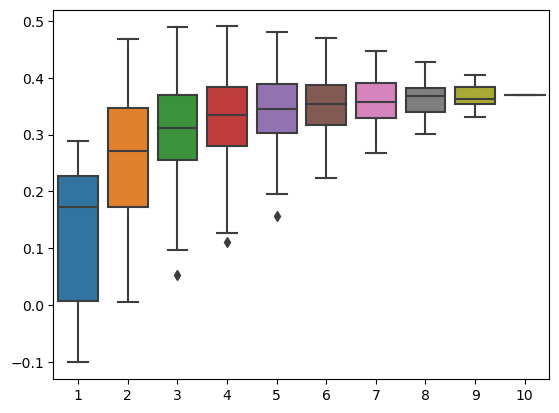

In [206]:
sns.boxplot(mme_size_to_results_df)

In [218]:
df_no_era = x_y_cv_filtered.loc[(x_y_cv_filtered["init_month"] == 10) & (x_y_cv_filtered["model"] != "ERA"), ['model', 'year', 'init_month'] + relevant_columns].reset_index(drop=True)
df_era = x_y_cv_filtered.loc[(x_y_cv_filtered["init_month"] == 12) & (x_y_cv_filtered["model"] == "ERA"), ['model', 'year', 'init_month'] + relevant_columns].reset_index(drop=True)
N = len(df_no_era["model"].unique().tolist())
model_to_error = {}

# calculate bias between each model and ERA
corr_matrices = []
for col in relevant_columns:
    model_to_error[col] = {}
    for model in relevant_models:
        bias = np.array(df_no_era.loc[df_no_era["model"] == model, col]) - np.array(df_era.loc[df_era["model"] == "ERA", col])
        model_to_error[col][model] = bias.flatten()
    df = pd.DataFrame(model_to_error[col])
    correlation_matrix = df.corr()
    corr_matrices.append(correlation_matrix)

correlation_matrix = sum(corr_matrices) / len(corr_matrices)
correlation_matrix


,BOM,ECCC,GFDL,CWB,NASA,ECMWF,METFR,JMA,KMA,NCEP
BOM,1.000000,0.647882,0.533879,0.663234,0.658891,0.764647,0.651531,0.699529,0.671617,0.750265
ECCC,0.647882,1.000000,0.597570,0.801494,0.776993,0.759513,0.580791,0.677072,0.617841,0.707607
GFDL,0.533879,0.597570,1.000000,0.674369,0.663638,0.571632,0.657740,0.625683,0.573497,0.711072
CWB,0.663234,0.801494,0.674369,1.000000,0.749780,0.791582,0.637103,0.646170,0.660079,0.770847
NASA,0.658891,0.776993,0.663638,0.749780,1.000000,0.727224,0.693653,0.680999,0.672606,0.758618
ECMWF,0.764647,0.759513,0.571632,0.791582,0.727224,1.000000,0.687342,0.746020,0.646611,0.833247
METFR,0.651531,0.580791,0.657740,0.637103,0.693653,0.687342,1.000000,0.670142,0.587890,0.718508
JMA,0.699529,0.677072,0.625683,0.646170,0.680999,0.746020,0.670142,1.000000,0.651347,0.697959
KMA,0.671617,0.617841,0.573497,0.660079,0.672606,0.646611,0.587890,0.651347,1.000000,0.668894
NCEP,0.750265,0.707607,0.711072,0.770847,0.758618,0.833247,0.718508,0.697959,0.668894,1.000000


In [221]:
metrics = []
correlations = []
for size in range(2,5):
    model_combinations = list(combinations([c for c in relevant_models if c != "ERA"], size))
    print(len(model_combinations))
    for i in range(0, len(model_combinations)):
        combi = list(model_combinations[i])
        mme = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(combi)].assign(model="MME_{}".format("_".join(combi))).groupby(["model", "year", "init_month"]).mean().reset_index()
        x_y_cv_mme = pd.concat([mme, x_y_cv_filtered], ignore_index=True)
        res, _ = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(combi)), init=10, no_of_features=6)
        #metric = pearsonr(res["yield anomaly [%]"], res["predicted"])[0]
        metric = r2_score(res["yield anomaly [%]"], res["predicted"])

        metrics.append(metric)
        corr = correlation_matrix.loc[correlation_matrix.index.isin(combi), combi].where(np.triu(np.ones(len(combi)), k=1).astype(bool)).stack().mean()
        correlations.append(corr)
    

45
120
210


In [222]:
metrics_to_correlation = pd.DataFrame(
    {'metrics': metrics,
     'correlation': correlations
    })
metrics_to_correlation.head()

,metrics,correlation
0,0.256918,0.647882
1,0.468227,0.533879
2,0.355673,0.663234
3,0.201777,0.658891
4,0.283978,0.764647


<Axes: xlabel='correlation', ylabel='metrics'>

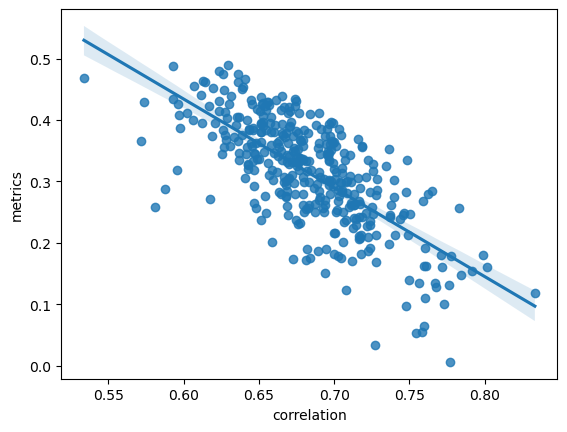

In [223]:
#sns.scatterplot(data=metrics_to_correlation, x="correlation", y="metrics")
sns.regplot(x = "correlation", y = "metrics", data = metrics_to_correlation)

In [235]:
mme = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(["BOM", "GFDL", "CWB", "KMA"])].assign(model="MME_{}".format("_".join(["BOM", "GFDL", "CWB", "KMA"]))).groupby(["model", "year", "init_month"]).mean().reset_index()
x_y_cv_mme = pd.concat([mme, x_y_cv_filtered], ignore_index=True)
res, year_to_features = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(["BOM", "GFDL", "CWB", "KMA"])), init=10, no_of_features=6)
features_2010 = year_to_features[2010].tolist()

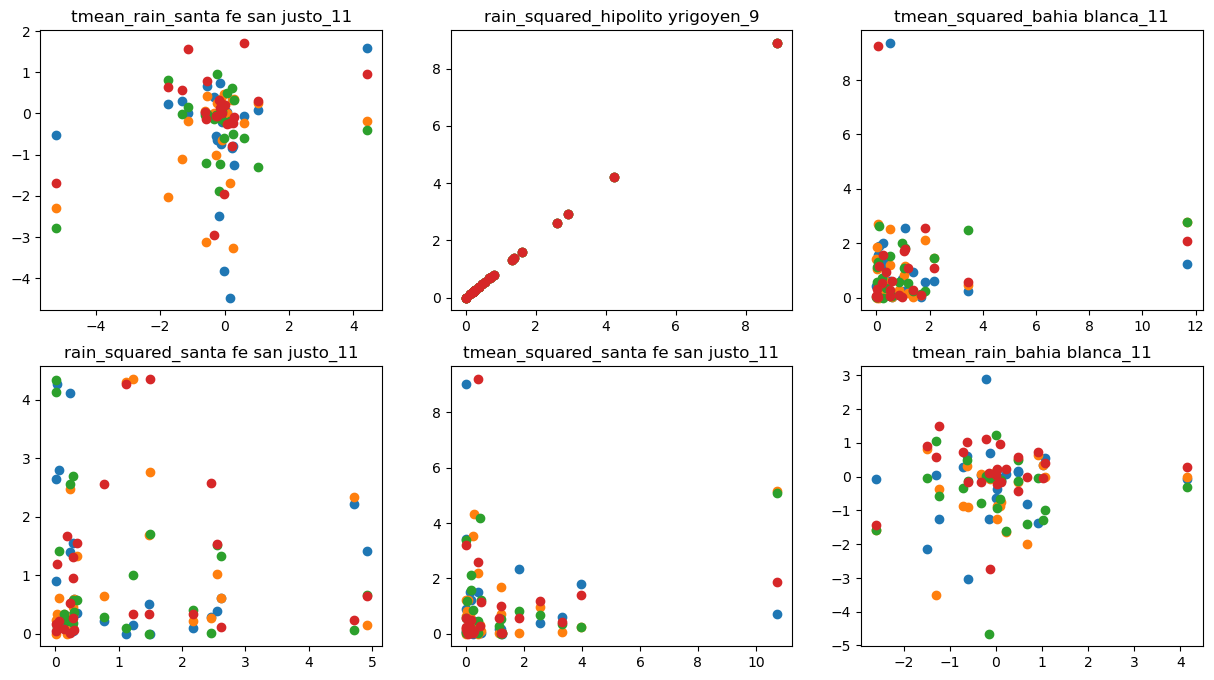

In [256]:
best_mme_df = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(["BOM", "GFDL", "CWB", "KMA", "ERA"])].reset_index(drop=True)

fig, axs = plt.subplots(2,3, figsize=(15,8))
axs = axs.ravel()

for counter, col in enumerate(features_2010):
    df = best_mme_df[["model", "year", col]].pivot(index="year", columns="model", values=col)
    axs[counter].scatter(y=df["BOM"], x=df["ERA"])
    axs[counter].scatter(y=df["GFDL"], x=df["ERA"])
    axs[counter].scatter(y=df["CWB"], x=df["ERA"])
    axs[counter].scatter(y=df["KMA"], x=df["ERA"])
    axs[counter].set_title(col)

In [229]:
mme = x_y_cv_filtered.loc[x_y_cv_filtered["model"].isin(["BOM", "GFDL", "CWB", "KMA"])].assign(model="MME_{}".format("_".join(["BOM", "GFDL", "CWB", "KMA"]))).groupby(["model", "year", "init_month"]).mean().reset_index()
x_y_cv_mme = pd.concat([mme, x_y_cv_filtered], ignore_index=True)
res, _ = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(["BOM", "GFDL", "CWB", "KMA"])), init=10, no_of_features=6)

# rmse
rmse = 100 * np.round(mse(res["yield anomaly [%]"], res["predicted"], squared=False), 3)
# r
r = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)

# coefficient of determination
r2 = np.round(r2_score(res["yield anomaly [%]"], res["predicted"]), 2)

print("rmse: {}; r: {}; R2: {}".format(rmse, r, r2))

rmse: 9.700000000000001; r: 0.7; R2: 0.49


<Axes: xlabel='year'>

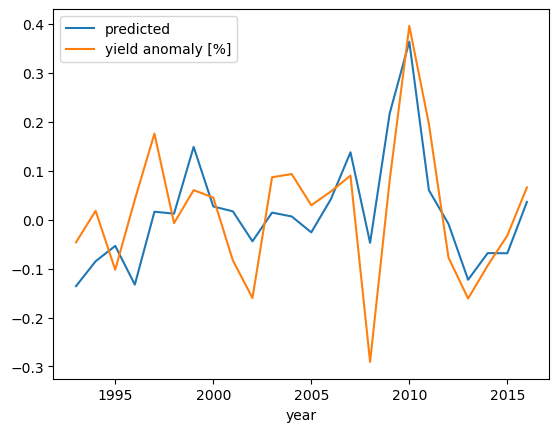

In [228]:
res.set_index("year").plot()